## Bone Fracture Deduction from X-Ray images

* Team Members: Walter Lizardo, Priyanka Aiyer, Abhav Vohra

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

#### Download MURA-V1.1 dataset to Colab

> https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip

In [2]:
! wget https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip

--2024-04-30 02:33:29--  https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3380245855 (3.1G) [application/zip]
Saving to: ‘MURA-v1.1.zip’

MURA-v1.1.zip       100%[===================>]   3.15G  3.67MB/s    in 11m 35s 

2024-04-30 02:45:05 (4.64 MB/s) - ‘MURA-v1.1.zip’ saved [3380245855/3380245855]



In [3]:
!ls "/content"

MURA-v1.1.zip  sample_data


###### Unzip the downloaded dataset file in Colab

In [4]:
!unzip -uq "/content/MURA-v1.1.zip" -d "/content/"

In [5]:
!ls "/content/MURA-v1.1/"

train		       train_labeled_studies.csv  valid_image_paths.csv
train_image_paths.csv  valid			  valid_labeled_studies.csv


#### Load the Train and Validation X-Ray image datasets from respective folders

In [6]:
train_path = "/content/MURA-v1.1/train"
os.listdir(train_path)

['XR_FINGER',
 'XR_HAND',
 'XR_SHOULDER',
 'XR_ELBOW',
 'XR_FOREARM',
 'XR_WRIST',
 'XR_HUMERUS']

In [7]:
validation_path = "/content/MURA-v1.1/valid"
os.listdir(validation_path)

['XR_FINGER',
 'XR_HAND',
 'XR_SHOULDER',
 'XR_ELBOW',
 'XR_FOREARM',
 'XR_WRIST',
 'XR_HUMERUS']

In [8]:
# Method to load the train and test data paths

def load_datapath(path):
  dataset = []

  for body in os.listdir(path):
      body_part = body
      path_body = path+'/'+str(body)

      for patient in os.listdir(path_body):
          patient_id = patient
          path_patient = path_body+'/'+str(patient)

          for labl in os.listdir(path_patient):
              if labl.split('_')[-1]=='positive':
                  label = 1
              elif labl.split('_')[-1]=='negative':
                  label = 0
              path_labl = path_patient+'/'+str(labl)

              for img in os.listdir(path_labl):
                  image = img
                  path_img = path_labl+'/'+str(img)

                  dataset.append(
                    {
                      'body_part': body_part,
                      'patient_id': patient_id,
                      'label': label,
                      'img_path': image
                    }
                  )
      return dataset


In [9]:
dataset = load_datapath(train_path)
df_train = pd.DataFrame(dataset)

In [10]:
df_train.head(4)

,body_part,patient_id,label,img_path
0,XR_FINGER,patient03502,1,image3.png
1,XR_FINGER,patient03502,1,image2.png
2,XR_FINGER,patient03502,1,image1.png
3,XR_FINGER,patient03998,0,image2.png


In [11]:
dataset_test = load_datapath(validation_path)
df_test = pd.DataFrame(dataset_test)

In [12]:
df_test.head(4)

,body_part,patient_id,label,img_path
0,XR_FINGER,patient11890,1,image2.png
1,XR_FINGER,patient11890,1,image1.png
2,XR_FINGER,patient11603,0,image3.png
3,XR_FINGER,patient11603,0,image2.png


### Data Preprocessing

In [13]:
df_train['lbl_idx']= df_train.label
df_train.lbl_idx.replace('positive', 1, inplace=True)
df_train.lbl_idx.replace('negative', 0, inplace=True)
df_train.head(4)

,body_part,patient_id,label,img_path,lbl_idx
0,XR_FINGER,patient03502,1,image3.png,1
1,XR_FINGER,patient03502,1,image2.png,1
2,XR_FINGER,patient03502,1,image1.png,1
3,XR_FINGER,patient03998,0,image2.png,0


In [14]:
df_test['lbl_idx']= df_test.label
df_test.lbl_idx.replace('positive', 1, inplace=True)
df_test.lbl_idx.replace('negative', 0, inplace=True)
df_test.head(4)

,body_part,patient_id,label,img_path,lbl_idx
0,XR_FINGER,patient11890,1,image2.png,1
1,XR_FINGER,patient11890,1,image1.png,1
2,XR_FINGER,patient11603,0,image3.png,0
3,XR_FINGER,patient11603,0,image2.png,0


### Explorative Data Analysis

In [15]:
print("Total training images is : ", len(df_train["img_path"]))

Total training images is :  5106


In [16]:
print("Total test images is : ", len(df_test["img_path"]))

Total test images is :  461


In [18]:
grouped = df_train.groupby(df_train.body_part)
df_XR_FINGER = grouped.get_group("XR_FINGER")

In [19]:
print("Total training images of FINGER bones : ",len(df_XR_FINGER))

Total training images of FINGER bones :  5106


In [20]:
grouped_lbl = df_train.groupby(df_train.label)
pos = len(grouped_lbl.get_group(1))
neg = len(grouped_lbl.get_group(0))

In [21]:
print("Number of positive labels:", pos)
print("Number of negative labels:", neg)

Number of positive labels: 1968
Number of negative labels: 3138


##### Plotting graph: Bone X-ray Status

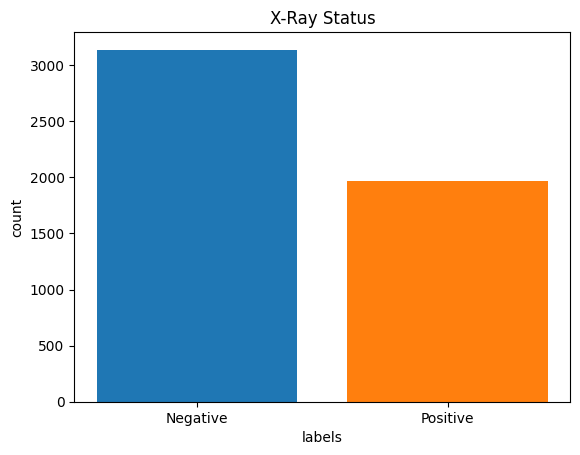

In [22]:
cat1 = ["Negative"]
val1 = [neg]
cat2 = ["Positive"]
val2 = [pos]

plt.bar(cat1, val1)
plt.bar(cat2, val2)

plt.title('X-Ray Status')
plt.xlabel('labels')
plt.ylabel('count')

plt.show()

#### Create CNN Model

#### Train the Model

#### Plot the Train and Test Accuracy curve

References: https://www.mdpi.com/2079-7737/11/5/665